![CDS 411 logo](../../img/cds-411-logo.png)

# Cellular automata II: Forest fire

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML

rc("animation", html="html5")

np.random.seed(1189773503)

## Initializing the System

In [2]:
def init_forest(n, prob_tree, prob_burning):
    forest = np.zeros(shape=(n, n), dtype=np.int)

    tree_cells = np.random.uniform(low=0, high=1, size=(n, n)) < prob_tree
    number_trees = np.prod(forest[tree_cells].shape)

    is_burning = np.random.uniform(low=0, high=1, size=number_trees) < prob_burning
    burning_cells = tree_cells.copy()
    np.place(burning_cells, tree_cells, is_burning)

    forest[tree_cells] = 1
    forest[burning_cells] = 2

    return forest

Let's test that the above function creates a forest as assumed.
Let's assume that we have a 50 ⨉ 50 grid, with each cell having an 80% chance of being a tree, and each tree having a 0.05% chance of being on fire:

In [3]:
forest = init_forest(50, 0.8, 0.0005)

A 50 ⨉ 50 grid is too large to inspect manually, so let's construct a heat map visualization.
Cells with 0 will visualized as black squares, cells with 1 will be visualized as blue squares, and cells with 2 will be visualized as orange squares:

In [4]:
def visualize_grid(grid, fig_width=6, fig_height=6, dpi=120):
    m, n = grid.shape

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

    cmap = LinearSegmentedColormap.from_list(
        "forestfire", ["black", "tab:blue", "tab:orange"]
    )

    im = ax.imshow(grid, cmap=cmap, interpolation="nearest", vmin=0, vmax=2)

    xticks_start, xticks_end = ax.get_xlim()
    yticks_start, yticks_end = ax.get_ylim()

    ax.xaxis.set_ticks(np.linspace(xticks_start, xticks_end, n + 1), minor=False)
    ax.yaxis.set_ticks(np.linspace(yticks_start, yticks_end, m + 1), minor=False)
    ax.axes.grid(True, linestyle="-", linewidth=0.3, color="white", which="major")

    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

    return fig, ax

So, for our example, we get the following heatmap:

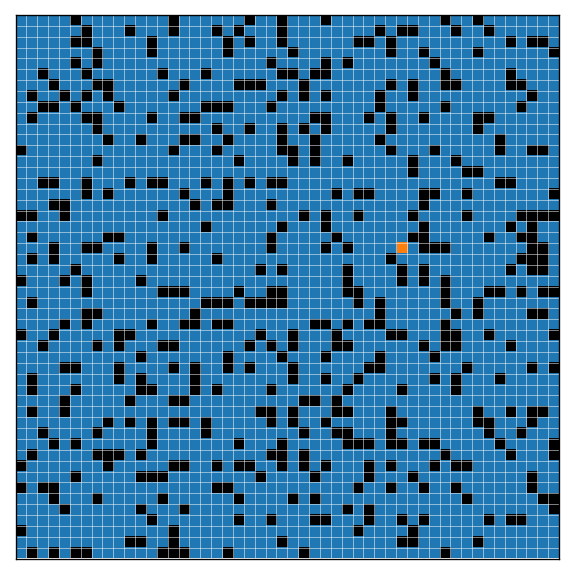

In [5]:
visualize_grid(forest, dpi=120);

This is exactly what we expected to see.

## Updating Rules

The forest fire model follows a set of relatively simple rules, which are as follows:

1.  A burning tree takes one time step to burn up completely
2.  If a tree cell has at least one neighbor that is burning, then there is a probability $(1-\texttt{prob_immune})$ that the cell will transition to the "burning" state
3.  For each time step, there is a probability $(\texttt{prob_lightning}\cdot(1-\texttt{prob_immune}))$ that a tree cell will be struck by lightning and catch fire

The forest fire simulation uses a **von Neumann neighborhood** to define each cell's neighbors, which consists of a cell's N, S, E, and W neighbors:

<table>
<tbody align="center">
  <tr>
    <td></td>
    <td>N</td>
    <td></td>
  </tr>
  <tr>
    <td>W</td>
    <td>site</td>
    <td>E</td>
  </tr>
  <tr>
    <td></td>
    <td>S</td>
    <td></td>
  </tr>
</tbody>
</table>


## Boundary Conditions

For the forest fire model, we will implement **periodic boundary conditions**.
We will use **ghost cells** for consistency with other boundary conditions when implementing the periodic boundary conditions, although they're not necessary in this case.
The following function sets up the ghost cells in `numpy`:

In [6]:
def boundary_condition(forest, condition="periodic"):
    if condition == "periodic":
        extended_forest = np.pad(array=forest, pad_width=(1, 1), mode='wrap')

    else:
        raise ValueError(
            "{0} is not a valid boundary condition".format(condition))

    return extended_forest

After adding the ghost cells, we now have an extended forest.
With this set up, we can now go through each site and look up the neighboring cell states in the von Neumann neighborhood.
We can do this efficiently using `numpy`:

In [7]:
def get_neighbors(extended_forest, ghost_width=(1, 1), neighborhood="von_neumann"):
    m_extended, n_extended = extended_forest.shape
    m, n = (m_extended - ghost_width[0], n_extended - ghost_width[1])

    if neighborhood == "von_neumann":
        forest_with_neighbors = np.array(
            [
                np.roll(extended_forest, shift=(0, 1), axis=(1, 0))[
                    ghost_width[0] : m, ghost_width[1] : n
                ],
                np.roll(extended_forest, shift=(1, 0), axis=(1, 0))[
                    ghost_width[0] : m, ghost_width[1] : n
                ],
                np.roll(extended_forest, shift=(-1, 0), axis=(1, 0))[
                    ghost_width[0] : m, ghost_width[1] : n
                ],
                np.roll(extended_forest, shift=(0, -1), axis=(1, 0))[
                    ghost_width[0] : m, ghost_width[1] : n
                ],
            ]
        )

    else:
        raise ValueError("{0} is not a valid type of neighborhood".format(condition))

    return forest_with_neighbors

## Applying a Function to Each Grid Point

Now that we're able to obtain the state of neighboring cells, we implement the update rules discussed earlier.
This involves sweeping over the entire grid and using a random number generator to determine if there are any state transitions.

As usual, we can do this efficiently with `numpy` and vectorization with the use of boolean conditions and operators to determine which cells require updateing.
Note that we do not have any `for` loops below.

In [8]:
def spread(forest, forest_neighbors, prob_immune, prob_lightning):
    # Get number of neighbors per cell and x,y dimensions
    num_neighbors, m, n = forest_neighbors.shape

    # Use copy of forest to help prevent premature updating of cellular states.
    forest_update = forest.copy()

    # Find the tree cells and burning cells
    tree_cells = forest_update == 1
    old_burning_cells = forest_update == 2

    # Compute the probability that a lightning strike causes a fire.
    prob_lightning_fire = prob_lightning * (1 - prob_immune)

    # Boolean condition: which cells have a burning neighbor?
    cells_with_burning_neighbors = np.any(forest_neighbors == 2, axis=0)

    # Boolean condition: Which of the cells with burning neighbors has a tree
    # state
    trees_with_burning_neighbors = np.logical_and(
        tree_cells, cells_with_burning_neighbors
    )
    number_trees_with_burning_neighbors = np.sum(trees_with_burning_neighbors)

    # Generate a random number to determine how the fire spreads:
    is_burning = (
        np.random.uniform(low=0, high=1, size=number_trees_with_burning_neighbors)
        >= prob_immune
    )

    # Create an array and fill it with the False boolean, then use np.place()
    # with trees_with_burning_neighbors to label the sites that will burn
    trees_catching_fire = np.full(fill_value=False, shape=(m, n), dtype=np.bool)
    np.place(trees_catching_fire, trees_with_burning_neighbors, is_burning)

    # Next, we test if lightning strikes and causes a fire.
    # Remove the trees from our list that will already catch fire this round
    tree_cells[trees_catching_fire] = False
    number_remaining_trees = np.sum(tree_cells)

    # Check if each tree cell gets hit by lightning AND starts a fire
    is_burning = (
        np.random.uniform(low=0, high=1, size=number_remaining_trees)
        < prob_lightning_fire
    )
    trees_burned_by_lightning = np.full(fill_value=False, shape=(m, n), dtype=np.bool)

    # Use np.place() to mark the cells with trees burned by lightning for
    # update
    np.place(trees_burned_by_lightning, tree_cells, is_burning)

    # Combine burning trees from spreading and lightning into one list
    new_burning_cells = np.logical_or(trees_catching_fire, trees_burned_by_lightning)

    # Update states
    # Replace trees that burned in the previous round with an empty square
    forest_update[old_burning_cells] = 0

    # Use combined list of trees to burn during the next time step to update
    # their state:
    forest_update[new_burning_cells] = 2

    return forest_update

Now we sweep over all lattice points.
In addition to the spread routine defined above, we also append the updated grid to the `simulation_history` list so that we can animate the diffusion simulation.

In [9]:
def sweep(forest, prob_immune, prob_lightning, nstep, simulation_history):
    extended_forest = boundary_condition(forest)
    forest_neighbors = get_neighbors(extended_forest)
    forest_update = spread(forest, forest_neighbors, prob_immune, prob_lightning)
    forest[:, :] = forest_update
    simulation_history.append([nstep, forest_update])

## Simulation Program

Finally, we bring it all together into a function that runs the full simulation from start to finish.
This is where we put our `for` loop over time.

In [10]:
def forest_fire_simulation(
    number_time_steps, n, prob_tree, prob_burning, prob_immune, prob_lightning
):
    forest = init_forest(n, prob_tree, prob_burning)
    simulation_history = [[0, forest.copy()]]

    for nstep in np.arange(1, number_time_steps + 1):
        sweep(forest, prob_immune, prob_lightning, nstep, simulation_history)

    return simulation_history

## Display Simulation

Having successfully run our simulation, now we would like to see it in action!
We advance each frame of the animation by incrementing the index on `simulation_history` by 1.

In [11]:
def ca_animation(simulation_history, fig_width=6, fig_height=6, dpi=120):
    m, n = simulation_history[0][1].shape

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

    cmap = LinearSegmentedColormap.from_list(
        "forestfire", ["black", "tab:blue", "tab:orange"]
    )
    im = ax.imshow(
        simulation_history[0][1], cmap=cmap, interpolation="nearest", vmin=0, vmax=2
    )

    xticks_start, xticks_end = ax.get_xlim()
    yticks_start, yticks_end = ax.get_ylim()

    ax.xaxis.set_ticks(np.linspace(xticks_start, xticks_end, n + 1), minor=False)
    ax.yaxis.set_ticks(np.linspace(yticks_start, yticks_end, m + 1), minor=False)
    ax.axes.grid(True, linestyle="-", linewidth=0.3, color="white", which="major")

    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

    def init():
        im.set_array(np.array([[]]))
        return (im,)

    def animate(i):
        forest_i = simulation_history[i][1]
        im.set_array(forest_i)

        return (im,)

    plt.close()

    anim = animation.FuncAnimation(
        fig=fig,
        func=animate,
        frames=len(simulation_history),
        init_func=init,
        interval=100,
        blit=True,
    )

    return anim

## Example Run

Now that all the pieces are in place, let's run the simulation with the following initial parameters, which match the parameters suggested in the textbook.

In [12]:
n = 50
prob_tree = 0.80
prob_burning = 0.0005
prob_immune = 0.25
prob_lightning = 0.00001
number_time_steps = 100

simulation_history = forest_fire_simulation(
    number_time_steps, n, prob_tree, prob_burning, prob_immune, prob_lightning
)

We then build our animation:

In [13]:
anim = ca_animation(simulation_history, dpi=120)

And view it:

In [ ]:
HTML(anim.to_html5_video())

### Analysis of run

We can take the results of the simulation and restructure them for storage in a data frame. The main thing we need to do is be able to identify the *x* and *y* indices for the two-dimensional array. We then can **flatten** the arrays to store as a single column.

In [15]:
simulation_history2 = np.array([simarray[1] for simarray in simulation_history])
nsteps_idx, grid_x_idx, grid_y_idx = np.indices(simulation_history2.shape)
trace_df = pd.DataFrame({
    "nstep": nsteps_idx.flatten(),
    "x": grid_x_idx.flatten(),
    "y": grid_y_idx.flatten(),
    "state": simulation_history2.flatten(),
})

The rows at the top and bottom of the array now look like this:

In [16]:
trace_df.head(10)

,nstep,x,y,state
0,0,0,0,1
1,0,0,1,1
2,0,0,2,1
3,0,0,3,0
4,0,0,4,1
5,0,0,5,1
6,0,0,6,1
7,0,0,7,1
8,0,0,8,1
9,0,0,9,0


In [17]:
trace_df.tail(10)

,nstep,x,y,state
252490,100,49,40,0
252491,100,49,41,0
252492,100,49,42,0
252493,100,49,43,0
252494,100,49,44,0
252495,100,49,45,1
252496,100,49,46,0
252497,100,49,47,0
252498,100,49,48,0
252499,100,49,49,0


Now that the array is reshaped, we can count the number of empty cells, tree cells, and burning cells as a function of time steps. We can do this by grouping over the `nstep` column, and then for each `nstep` group, counting the number of rows with a `state` value of 0, 1, and 2. We label these `nempty`, `ntrees`, and `nburning`. We then reshape the data frame to make it more amenable to plotting with `seaborn`:

In [18]:
state_count = trace_df \
    .groupby("nstep") \
    .apply(
        func=lambda x: pd.Series([len(x[x["state"] == 0]), len(x[x["state"] == 1]), len(x[x["state"] == 2])],
                                 index=["nempty", "ntrees", "nburning"])) \
    .reset_index() \
    .melt(id_vars=["nstep"], var_name="state", value_name="count") \
    .assign(fraction=lambda x: x["count"] / (n * n))

Our data frame's first few rows are now:

In [19]:
state_count.head(10)

,nstep,state,count,fraction
0,0,nempty,511,0.2044
1,1,nempty,514,0.2056
2,2,nempty,522,0.2088
3,3,nempty,535,0.2140
4,4,nempty,550,0.2200
5,5,nempty,565,0.2260
6,6,nempty,587,0.2348
7,7,nempty,612,0.2448
8,8,nempty,634,0.2536
9,9,nempty,656,0.2624


Now we can easily plot the number of empty cells, trees, and burning trees as a function of time steps:

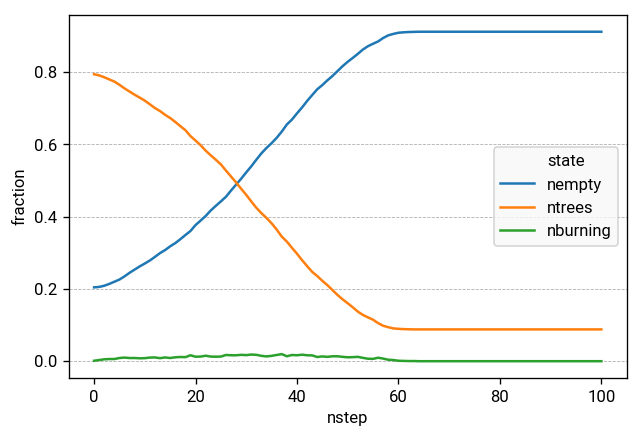

In [20]:
fig, ax = plt.subplots(dpi=120)
sns.lineplot(x="nstep", y="fraction", hue="state", data=state_count, ax=ax);

If there is a specific frame of the simulation that you wish to view, you can convert from the data frame back to a numpy array for a specific value of `nstep` as follows:

```python
trace_df \
    .query("nstep == 50") \  # Query for nstep = 50 frame
    .loc[:, "state"] \      # Just get the state column
    .values \               # Converts from pandas Series/DataFrame to numpy array
    .reshape(50, 50)        # Original dimensions of unflattened array.
```

You can then visualize the grid with `visualize_grid`.

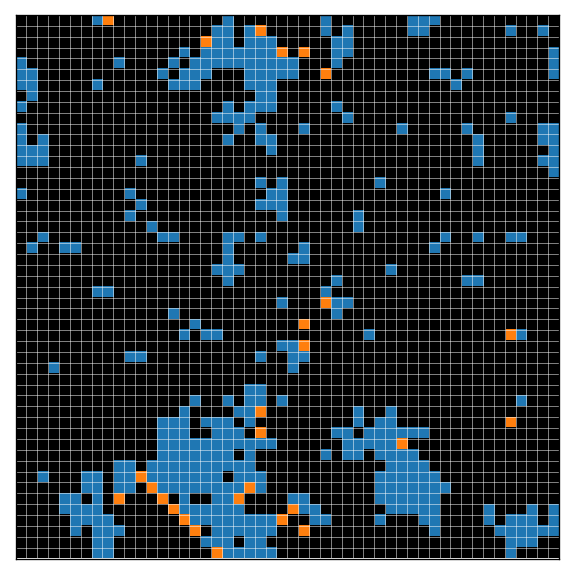

In [21]:
visualize_grid(trace_df.query("nstep == 50").loc[:, "state"].values.reshape((n, n)));

## Scenario Case Study

Since the forest fire simulation contains random elements, there are a number of scenarios that may play out during any given run. To illustrate, let's plot the number of trees as a function of time for multiple simulation runs:

In [22]:
import forest_fire as firesim

In [23]:
n = 50
prob_tree = 0.80
prob_burning = 0.0005
prob_immune = 0.25
prob_lightning = 0.00001
number_time_steps = 150

list_of_state_counts = []

for sim_number in range(1, 101):
    simulation_history = firesim.forest_fire_simulation(
        number_time_steps, n, prob_tree, prob_burning, prob_immune, prob_lightning
    )
    trace_df = firesim.make_trace_data_frame(simulation_history)
    state_count = firesim.count_states_over_time(trace_df, n)
    state_count["sim_number"] = sim_number
    
    list_of_state_counts.append(state_count)
    
state_count_all_sims = pd.concat(list_of_state_counts)

In [24]:
state_count_all_sims.head()

,nstep,state,count,fraction,sim_number
0,0,nempty,459,0.1836,1
1,1,nempty,459,0.1836,1
2,2,nempty,459,0.1836,1
3,3,nempty,459,0.1836,1
4,4,nempty,459,0.1836,1


In [25]:
state_count_all_sims.tail()

,nstep,state,count,fraction,sim_number
448,146,nburning,0,0.0,100
449,147,nburning,0,0.0,100
450,148,nburning,0,0.0,100
451,149,nburning,0,0.0,100
452,150,nburning,0,0.0,100


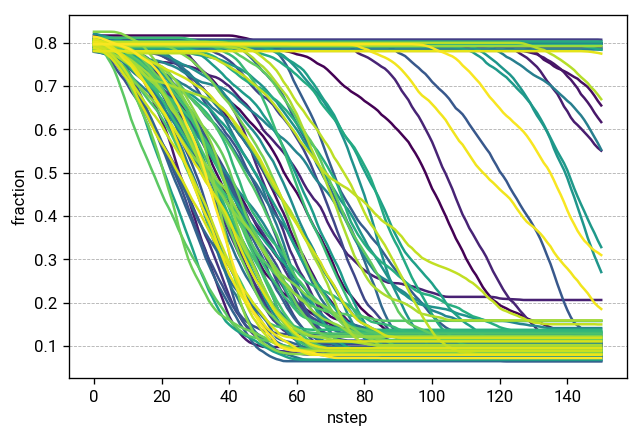

In [26]:
fig, ax = plt.subplots(dpi=120)
sns.lineplot(
    x="nstep",
    y="fraction",
    hue="sim_number",
    palette="viridis",
    data=state_count_all_sims.query("state == 'ntrees'"),
    legend=False,
    ax=ax,
)


Let's make this a little more systematic.

In [27]:
n = 50
prob_tree = 0.80
prob_burning = 0.0
number_burning_trees = 1
prob_immune = 0.25
prob_lightning = 0.0
number_time_steps = 150

list_of_state_counts = []

for sim_number in range(1, 101):
    simulation_history = firesim.forest_fire_simulation(
        number_time_steps, n, prob_tree, prob_burning, prob_immune, prob_lightning, number_burning_trees
    )
    trace_df = firesim.make_trace_data_frame(simulation_history)
    state_count = firesim.count_states_over_time(trace_df, n)
    state_count["sim_number"] = sim_number
    
    list_of_state_counts.append(state_count)
    
state_count_all_sims = pd.concat(list_of_state_counts)


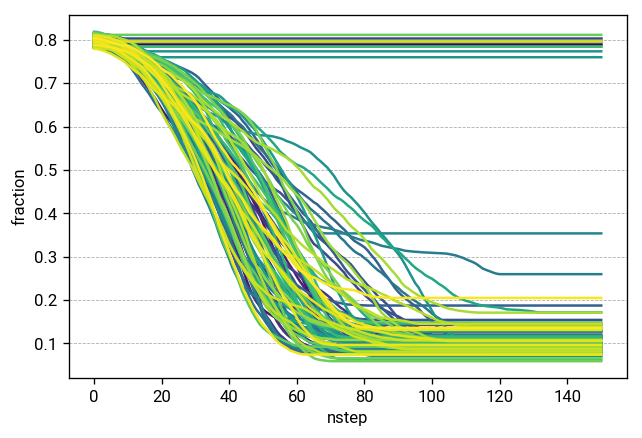

In [28]:
fig, ax = plt.subplots(dpi=120)
sns.lineplot(
    x="nstep",
    y="fraction",
    hue="sim_number",
    palette="viridis",
    data=state_count_all_sims.query("state == 'ntrees'"),
    legend=False,
    ax=ax,
);


In [29]:
ntrees_sim_end = state_count_all_sims \
    .query("state == 'ntrees'") \
    .loc[:, ["sim_number", "state", "fraction"]] \
    .groupby(["sim_number"]) \
    .last()


/home/jglasbr2/.conda/envs/cds411-dev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


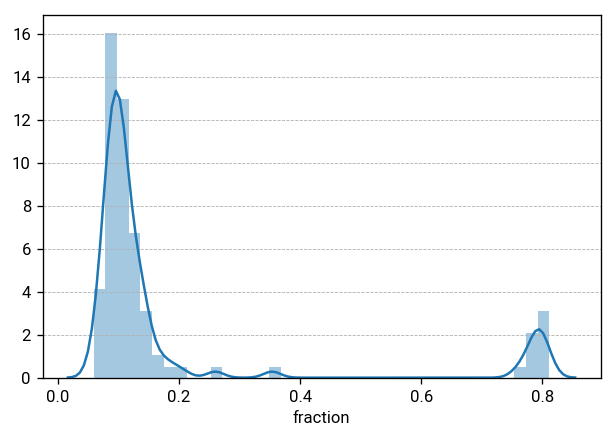

In [30]:
fig, ax = plt.subplots(dpi=120)
sns.distplot(ntrees_sim_end["fraction"], ax=ax);

In [31]:
ntrees_sim_end["fraction"].median()

0.1056

In [32]:
def simulate_median_trees_remaining(n, prob_tree, number_burning_trees, prob_immune, number_time_steps, number_sim_runs):
    prob_burning = 0.0
    prob_lightning = 0.0
    
    list_of_state_counts = []
    
    for sim_number in range(1, number_sim_runs + 1):
        simulation_history = firesim.forest_fire_simulation(
            number_time_steps, n, prob_tree, prob_burning, prob_immune, prob_lightning, number_burning_trees
        )
        trace_df = firesim.make_trace_data_frame(simulation_history)
        state_count = firesim.count_states_over_time(trace_df, n)
        state_count["sim_number"] = sim_number
        
        list_of_state_counts.append(state_count)
        
    state_count_all_sims = pd.concat(list_of_state_counts)
    
    ntrees_sim_end = state_count_all_sims \
        .query("state == 'ntrees'") \
        .loc[:, ["sim_number", "state", "fraction"]] \
        .groupby(["sim_number"]) \
        .last()
    
    median_trees_left = ntrees_sim_end["fraction"].median()
    
    return median_trees_left


### Sweep

In [33]:
n = 50
prob_tree = 0.80
number_burning_trees = 1
prob_immune = 0.25
number_time_steps = 150
number_sim_runs = 100

median_trees_left_all_runs = {
    "prob_tree": [],
    "median_trees_left": [],
}

for prob_tree in np.arange(0.10, 1.00, 0.10):
    median_trees_left = simulate_median_trees_remaining(
        n,
        prob_tree,
        number_burning_trees,
        prob_immune,
        number_time_steps,
        number_sim_runs,
    )

    median_trees_left_all_runs["prob_tree"].append(prob_tree)
    median_trees_left_all_runs["median_trees_left"].append(median_trees_left)

median_trees_left_df = pd.DataFrame(median_trees_left_all_runs)

In [34]:
median_trees_left_df["ratio"] = median_trees_left_df["median_trees_left"] / median_trees_left_df["prob_tree"]

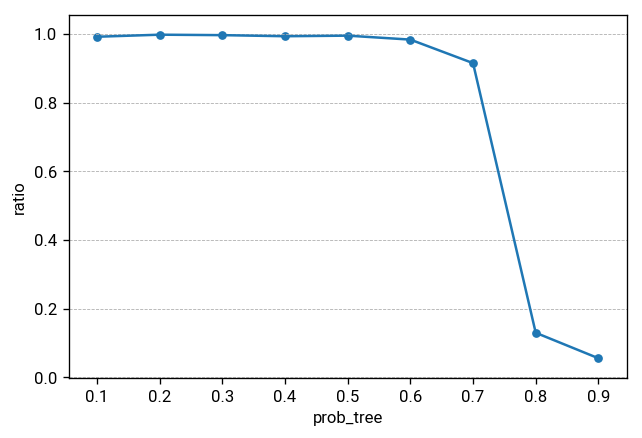

In [35]:
fig, ax = plt.subplots(dpi=120)
sns.lineplot(x="prob_tree", y="ratio", data=median_trees_left_df, ax=ax)
sns.scatterplot(x="prob_tree", y="ratio", data=median_trees_left_df, ax=ax);

There is a phase transition in the region $0.70\leq\tt{prob\_tree}\leq0.8$, where the percentage of the forest that burns down dramatically changes.